# CSCI-E82

## Shakespeare plays analysis

**Harvard University**<br/>
**Team**: Aniket Shah , Ansuman Prusty

### Motivation

The aim of this assignment is to analyze Shakespeare plays and determine whether some of the plays or parts of plays were not written by Shakespeare

### Description

A number of Shakespeare plays along with its sections are given in a data-set available in Kaggle. The data-set is cleaned by dropping the NA values. After that, various sub-section lines are merged into a single section. For example, the sub-sections like 1.1.1, 1.1.2, etc are merged into 1.1.

Once the data is grouped into sections, various syntactic, semantic and functional features of the sections are extracted and clustered to identify the sections which have not been written by Shakespeare. Since, it is very unlikely that Shakespeare might not have any contribution to the whole play, our analysis was done on various sub-sections of the plays. Also, it will help us give a more granular picture on the various sections across different plays which might not have been written by Shakespeare.

### Feature Extraction

A total of 6 types of feature extraction techniques are applied to the Shakespeare plays. They are described in detailed in a later section below in the notebook.

### Clustering and Ensemble voting

Once the different features are extracted, clustering is applied one each set of features to divide them into groups of two. One group of sections will correspond to Shakespeare and the other to non-Shakespeare authors. The majority group is given to Shakespeare, with the assumption thatthe majority of sections will have been written by him. After that, ensemble voting is done across the various clustering groups for different set of features. Then by using majority voting, we determine if a section is written by Shakespeare or not. For example, let's say cluster 0 corresponds to Shakespeare plays and cluster 1 to non-Shakespeare plays. If section 1.1 belongs to cluster 0 for features 0, 1, 2  and 3 to cluster 1 for features 4 and 5. We can conclude that section 1.1 belong to cluster 0 since it was found to be in cluster 0 for 4 different features. And in case of ties, where the section is present in equal number of cluster groups for various sections, we consider it as a tie, and assign it to shakespeare, given the benfit of doubt.

After ensemble voting is done, various sections corresponding to non-Shakespeare authors are determined and printed for reference. It was found that around 100 sections out of total 732 sections had patterns different to those of Shakespearan written sections, and hence, possibly written by other authors.

### Different types of clustering and the optimum number of clusters

KMeans, DBScan and Agglomerative clustering (a type of hierarchical clustering) are tried for the clustering. And Silhouette score measure is used to identify the optimum number of clusters in each of the techniques. It was found that across the various features, using the Silhouette score, 2 was found as the optimum cluster number for k-means and agglomerative clustering. 

It was also found that DBscan gave only one cluster for all the features. So it was dropped from our clustering schemes and only Kmeans/Agglomerative clustering are used for the clustering.

In [1]:
import os
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from time import time

# Text pipeline and NLP packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Binarizer, Normalizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords  #pip install nltk
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import make_pipeline
import string
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering 
from sklearn.metrics import silhouette_samples, silhouette_score
from collections import Counter

### Data is read and the first few rows displayed to get a view of the data

In [2]:
df_data = pd.read_csv('Shakespeare_data.csv')
df_data.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [3]:
df_data.shape

(111396, 6)

### Data is cleaned by dropping all the NA values.

In [4]:
df_data_filter = df_data.dropna()

### In the following few cells, data is grouped by combining all the sub-sections into a single section.

In [5]:
df_data_filter['Scene'] = df_data_filter['ActSceneLine'].apply(lambda scene: scene.split('.')[0] + '.' + scene.split('.')[1])

c:\users\skywalker\anaconda3\envs\cscie82\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
df_data_filter.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Scene
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,",1.1
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,",1.1
5,6,Henry IV,1.0,1.1.3,KING HENRY IV,And breathe short-winded accents of new broils,1.1
6,7,Henry IV,1.0,1.1.4,KING HENRY IV,To be commenced in strands afar remote.,1.1
7,8,Henry IV,1.0,1.1.5,KING HENRY IV,No more the thirsty entrance of this soil,1.1


In [7]:
df_data_filter['Scene'] = df_data_filter['Scene'].astype(float)

c:\users\skywalker\anaconda3\envs\cscie82\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
df_scene = df_data_filter.groupby(['Play', "Scene"])['PlayerLine'].apply(' '.join).reset_index()

### The modified data-set is printed below for reference.

In [9]:
df_scene.head()

,Play,Scene,PlayerLine
0,A Comedy of Errors,1.1,"Proceed, Solinus, to procure my fall And by th..."
1,A Comedy of Errors,1.2,"Therefore give out you are of Epidamnum, Lest ..."
2,A Comedy of Errors,2.1,"Neither my husband nor the slave return'd, Tha..."
3,A Comedy of Errors,2.2,ANTIPHOLUS The gold I gave to Dromio is laid u...
4,A Comedy of Errors,3.1,"ANTIPHOLUS Good Signior Angelo, you must excus..."


In [10]:
df_scene.iloc[0]['PlayerLine']

"Proceed, Solinus, to procure my fall And by the doom of death end woes and all. Merchant of Syracuse, plead no more, I am not partial to infringe our laws: The enmity and discord which of late Sprung from the rancorous outrage of your duke To merchants, our well-dealing countrymen, Who wanting guilders to redeem their lives Have seal'd his rigorous statutes with their bloods, Excludes all pity from our threatening looks. For, since the mortal and intestine jars 'Twixt thy seditious countrymen and us, It hath in solemn synods been decreed Both by the Syracusians and ourselves, To admit no traffic to our adverse towns Nay, more, If any born at Ephesus be seen At any Syracusian marts and fairs, Again: if any Syracusian born Come to the bay of Ephesus, he dies, His goods confiscate to the duke's dispose, Unless a thousand marks be levied, To quit the penalty and to ransom him. Thy substance, valued at the highest rate, Cannot amount unto a hundred marks, Therefore by law thou art condemne

In [11]:
#Creating a key by combining the play and section.
df_scene['Play-Scene-Key'] = df_scene['Scene'].map(str) + ' ' + df_scene['Play']
df_scene.head()

,Play,Scene,PlayerLine,Play-Scene-Key
0,A Comedy of Errors,1.1,"Proceed, Solinus, to procure my fall And by th...",1.1 A Comedy of Errors
1,A Comedy of Errors,1.2,"Therefore give out you are of Epidamnum, Lest ...",1.2 A Comedy of Errors
2,A Comedy of Errors,2.1,"Neither my husband nor the slave return'd, Tha...",2.1 A Comedy of Errors
3,A Comedy of Errors,2.2,ANTIPHOLUS The gold I gave to Dromio is laid u...,2.2 A Comedy of Errors
4,A Comedy of Errors,3.1,"ANTIPHOLUS Good Signior Angelo, you must excus...",3.1 A Comedy of Errors


In [12]:
import nltk
nltk.download('punkt')
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Skywalker\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
scenes = df_scene['PlayerLine'].tolist()
allPlayText = ' '.join(scenes)

In [14]:
#Instead of using the pre-trained model for the english language, we train the model based on the given text as shakespearn english
# is a bit different than modern english
sentence_tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer(train_text=allPlayText)
word_tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

### Extraction of various textual features

1. Word Analysis: Stats such as average and standard deviation of the number of words in a sentence, and the diversity (number of unique words vs. total words) were collected for each section.  
  
  
2. Punctuation analysis: An author's signature can include the unique combination of punctuation marks used in his/her writing. So, we takes stats of the number of commas, colons and semicolons user per sentence for each section.  
  
  
3. BagOfWords: This feature takes the top 100 words found in the entire text, and counts the occurence of each for every section. To not many columns (100), we reduce the dimensions by applying TruncatedSVD on the count matrix.  
  
  
4. Funtional BagOfWords: This feature is similar to the one above except that the vocabulary includes only functional words, modified for  16-17th century, that are known to help define an authors signature in word adjacency networks according to research. Functional words found in Shakespearan english which are different than modern english. Note, words like 'yt it' represent it, 'wid wyth wytt wi wt wth' represent with and are not misspellings. Functional word source: http://web.mit.edu/segarra/www/papers/MSc_Thesis_Segarra.pdf  
  
  
5. ScenesLSA: This feature is the tf-idf matrix of all words in the collection that occur in atleast 75 sections, and reduced dimensionaly using TruncateSVD (LSA).  
  
  
6. ngramTFIDF: This feature is a tf-idf matrix of unigrams, bigrams and tri-grams that occur in atleast 75 sections, and no more than 20% of the sections. The average sentence length is approximately 3 accross the collection and hence this shoud capture some common sentenes/phrases across sections.

##### Note:  
Couple of feaures like tf-idf matrix of functional words and parts-of-speech tags were not found to be useful for the shakespeare corpus.

In [15]:
functional_words_shakespeare = """a both in no past this while about but into none shall
those who after by it nor should though whom
against can like nothing since through whose
all close little of so till will
an could many off some to with
and dare may on such until within
another down might once than unto without
any enough more one that up would
as every most or the upon yet
at for much other them us
away from must our then what
bar given need out therefore when
because hence neither over these where
before if next part they which
yt t offe o thatt thate yat wid wyth wytt wi wt wth"""
functional_words_list = functional_words_shakespeare.split()

In [16]:
def LexicalFeatures():
    """
    Compute feature vectors for word and punctuation features
    """
    num_scenes = len(scenes)
    word_features = np.zeros((num_scenes, 3), np.float64)
    punct_features = np.zeros((num_scenes, 3), np.float64)
    for i, scene_text in enumerate(scenes):
        
        tokens = nltk.word_tokenize(scene_text.lower())
        words = word_tokenizer.tokenize(scene_text.lower())
        sentences = sentence_tokenizer.tokenize(scene_text)
        vocab = set(words)
        words_per_sentence = np.array([len(word_tokenizer.tokenize(s)) for s in sentences])

        # average number of words per sentence
        word_features[i, 0] = words_per_sentence.mean()
        # sentence length variation
        word_features[i, 1] = words_per_sentence.std()
        # Diversity of text
        word_features[i, 2] = len(vocab) / float(len(words))

        # Commas per sentence
        punct_features[i, 0] = tokens.count(',') / float(len(sentences))
        # Semicolons per sentence
        punct_features[i, 1] = tokens.count(';') / float(len(sentences))
        # Colons per sentence
        punct_features[i, 2] = tokens.count(':') / float(len(sentences))
    
    # whitening to decorrelate the features
    word_features = whiten(word_features)
    punct_features = whiten(punct_features)

    return word_features, punct_features

def BagOfWords():
    """
    Bag of Words on the 100 most common words, followed by TruncatedSVD
    """
    # get most common words in the whole book
    NUM_TOP_WORDS = 100
    all_tokens = nltk.word_tokenize(allPlayText)
    fdist = nltk.FreqDist(all_tokens)
    vocab = list(fdist.keys())[:NUM_TOP_WORDS]

    vectorizer = CountVectorizer(vocabulary=vocab, tokenizer=nltk.word_tokenize)
    common_bow = vectorizer.fit_transform(scenes)
    #10 features still explains 95% of the variance
    svd_common = TruncatedSVD(10)
    lsa1 = make_pipeline(svd_common, Normalizer(copy=False))
    scenes_common_lsa = lsa1.fit_transform(common_bow)

    return scenes_common_lsa

def functionalBagOfWords():   
    """
    Bag of Words on the funtcional words that occur in atleast 100 sections
    """
    
    functionalVectorizer = CountVectorizer(min_df=100, vocabulary=functional_words_list, tokenizer=nltk.word_tokenize)
    functional_bow = functionalVectorizer.fit_transform(scenes).toarray().astype(np.float64)
    
    # normalise by dividing each row by its Euclidean norm
    functional_bow /= np.c_[np.apply_along_axis(np.linalg.norm, 1, functional_bow)]
    
    return functional_bow

def scenesLSA():
    """
    TFIDF of words that appear in atleast 75 sections, followed by SVD to reduce dimensionality
    """
    vectorizerTFIDF = TfidfVectorizer(max_features=10000,min_df=75, stop_words='english',use_idf=True)
    Scenestfidf = vectorizerTFIDF.fit_transform(scenes)
    svd = TruncatedSVD(200)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    scenes_lsa = lsa.fit_transform(Scenestfidf)
#     explained_variance = svd.explained_variance_ratio_.sum()
#     print(explained_variance)
    return scenes_lsa

# Average sentence/phrase length is about 3 words accros the plays, hence creating a ngram tfidf of 1-3 terms 
# with a min_df of 75, and max of 0.2. 
def ngramTFIDF():
    """
    TFIDF matrix of common unigram, bigram and trigrams
    """
    ngram_vectorizer = TfidfVectorizer(max_df=0.2, min_df = 75, ngram_range=(1,3), use_idf=True, smooth_idf=True)
    ScenesNGRAM_tfidf = ngram_vectorizer.fit_transform(scenes).toarray().astype(np.float64)
    ScenesNGRAM_tfidf /= np.c_[np.apply_along_axis(np.linalg.norm, 1, ScenesNGRAM_tfidf)]
    return ScenesNGRAM_tfidf


In [17]:
# Creating a Set of features
feature_sets = list(LexicalFeatures())
feature_sets.append(BagOfWords())
feature_sets.append(functionalBagOfWords())
feature_sets.append(scenesLSA())
feature_sets.append(ngramTFIDF())

c:\users\skywalker\anaconda3\envs\cscie82\lib\site-packages\scipy\cluster\vq.py:141: RuntimeWarning: Some columns have standard deviation zero. The values of these columns will not change.
  RuntimeWarning)


In [18]:
len(feature_sets)

6

### Following function determines the best clustering size for a given type of clustering across the various features computed above.

In [19]:
def findBestClusterSize(data_X, clusteringType):
    score = None
    best_cluster_size = None
    for n in np.arange(2,15):
        if (clusteringType == 1):
            clustering = KMeans(n_clusters=n, init='k-means++', random_state=10)
        elif (clusteringType == 2):
            clustering = DBSCAN(min_samples=10)
        elif (clusteringType == 3):
            clustering = AgglomerativeClustering(n_clusters=n)
        clustering.fit(data_X)
        if (len(set(clustering.labels_)) == 1):
            if (best_cluster_size is None):
                best_cluster_size = n
            continue
        silhouette_avg = silhouette_score(data_X, clustering.labels_)
        if (score is None or score < silhouette_avg):
            score = silhouette_avg
            best_cluster_size = n
    return best_cluster_size

In [20]:
for i in range(6):
    print("Kmeans best cluster size with feature_set {}: {}".format(i, findBestClusterSize(feature_sets[i], 1)))

Kmeans best cluster size with feature_set 0: 2
Kmeans best cluster size with feature_set 1: 2
Kmeans best cluster size with feature_set 2: 2
Kmeans best cluster size with feature_set 3: 2
Kmeans best cluster size with feature_set 4: 7
Kmeans best cluster size with feature_set 5: 8


In [21]:
for i in range(6):
    print("DBSCAN best cluster size with feature_set {}: {}".format(i, findBestClusterSize(feature_sets[i], 2)))

DBSCAN best cluster size with feature_set 0: 2
DBSCAN best cluster size with feature_set 1: 2
DBSCAN best cluster size with feature_set 2: 2
DBSCAN best cluster size with feature_set 3: 2
DBSCAN best cluster size with feature_set 4: 2
DBSCAN best cluster size with feature_set 5: 2


In [22]:
for i in range(6):
    print("Hierarchical best cluster size with feature_set {}: {}".format(i, findBestClusterSize(feature_sets[i], 3)))

Hierarchical best cluster size with feature_set 0: 2
Hierarchical best cluster size with feature_set 1: 2
Hierarchical best cluster size with feature_set 2: 2
Hierarchical best cluster size with feature_set 3: 2
Hierarchical best cluster size with feature_set 4: 14
Hierarchical best cluster size with feature_set 5: 2


### Optimum clustering size

KMeans, DBScan and Agglomerative clustering (a type of hierarchical clustering) are tried for the clustering. And Silhouette score measure is used to identify the optimum number of clusters in each of the techniques. It was found that across the various features, based on silhouette score, 2 was found as the optimum cluster number for k-means and agglomerative.

It was also found that DBscan had very low silhouette scores for all features and hence, was dropped from our clustering schemes and only Kmeans/Agglomerative clustering are used for the clustering.
From the above process, it is determined that a clustering size of 2 is the dominant one across the various features for the different types of clustering.

### Clustering is applied across the various sections for the different sets of feature groups.

In [23]:
def PredictAuthors(feature):
    """
    K-Means Clustering 
    """
    km = KMeans(n_clusters=2, init='k-means++', n_init = 1000, verbose=0, random_state=1237)
    km.fit(feature)

    return km

def PredictAuthorsAgglomerative(feature):
    aggCluster = AgglomerativeClustering(n_clusters=2)
    aggCluster.fit(feature)
    
    return aggCluster

def clusterVote(s):
    sum = s['LexicalFeaturesPred'] + s['PunctualFeaturesPred'] + s['BagOfWordsPred']  + s['FunctionalBOWPred']  + s['LSAPred'] + s['NGramTFIDFPred'] 
    if sum < 3:
        pred = 0
    elif sum > 3:
        pred = 1
    else:
        pred = 0.5
    return pd.Series({'majorityPred': pred})

In [24]:
#K-Means Clustering
classifications = [PredictAuthors(feature).labels_ for feature in feature_sets]
classificationDF = pd.DataFrame(classifications).T
classificationDF.columns = ['LexicalFeaturesPred', 'PunctualFeaturesPred','BagOfWordsPred', 'FunctionalBOWPred', 'LSAPred','NGramTFIDFPred']
classificationDF1 = classificationDF.merge(classificationDF.apply(clusterVote, axis=1), left_index=True, right_index=True)

In [25]:
classificationDF1.head()

,LexicalFeaturesPred,PunctualFeaturesPred,BagOfWordsPred,FunctionalBOWPred,LSAPred,NGramTFIDFPred,majorityPred
0,1,1,0,0,1,0,0.5
1,0,0,0,0,0,0,0.0
2,0,0,1,1,0,0,0.0
3,0,0,1,1,1,0,0.5
4,0,0,1,1,1,0,0.5


In [26]:
classificationDF1['majorityPred'].value_counts()

0.0    444
0.5    203
1.0     85
Name: majorityPred, dtype: int64

In [27]:
#Agglomerative Clustering
classificationsAgg = [PredictAuthorsAgglomerative(feature).labels_ for feature in feature_sets]
classificationAggDF = pd.DataFrame(classificationsAgg).T 
# joinedClassificationDF = classificationDF.join() + s['NGramTFIDFPred'] 'FunctionalTFIDFPred','POSFeaturesPred', + s['POSFeaturesPred']+ s['FunctionalTFIDFPred']
classificationAggDF.columns = ['LexicalFeaturesPred', 'PunctualFeaturesPred','BagOfWordsPred', 'FunctionalBOWPred','LSAPred','NGramTFIDFPred']
classificationAggDF1 = classificationAggDF.merge(classificationAggDF.apply(clusterVote, axis=1), left_index=True, right_index=True)

In [28]:
classificationAggDF1.head()

,LexicalFeaturesPred,PunctualFeaturesPred,BagOfWordsPred,FunctionalBOWPred,LSAPred,NGramTFIDFPred,majorityPred
0,1,0,0,1,1,0,0.5
1,0,0,0,1,0,0,0.0
2,0,1,0,0,0,0,0.0
3,0,1,1,0,0,0,0.0
4,0,1,1,0,0,0,0.0


In [29]:
classificationAggDF1['majorityPred'].value_counts()

0.0    509
0.5    178
1.0     45
Name: majorityPred, dtype: int64

In [30]:
classificationAggDF1.columns = ['LexicalFeaturesAggPred', 'PunctualFeaturesAggPred','BagOfWordsAggPred', 'FunctionalBOWAggPred','LSAAggPred','NGramTFIDFAggPred','majorityAggPred']
joinedDFKmeans = df_scene.join(classificationDF1)
joinedDfAll = joinedDFKmeans.join(classificationAggDF1)
joinedDfAll.head()

,Play,Scene,PlayerLine,Play-Scene-Key,LexicalFeaturesPred,PunctualFeaturesPred,BagOfWordsPred,FunctionalBOWPred,LSAPred,NGramTFIDFPred,majorityPred,LexicalFeaturesAggPred,PunctualFeaturesAggPred,BagOfWordsAggPred,FunctionalBOWAggPred,LSAAggPred,NGramTFIDFAggPred,majorityAggPred
0,A Comedy of Errors,1.1,"Proceed, Solinus, to procure my fall And by th...",1.1 A Comedy of Errors,1,1,0,0,1,0,0.5,1,0,0,1,1,0,0.5
1,A Comedy of Errors,1.2,"Therefore give out you are of Epidamnum, Lest ...",1.2 A Comedy of Errors,0,0,0,0,0,0,0.0,0,0,0,1,0,0,0.0
2,A Comedy of Errors,2.1,"Neither my husband nor the slave return'd, Tha...",2.1 A Comedy of Errors,0,0,1,1,0,0,0.0,0,1,0,0,0,0,0.0
3,A Comedy of Errors,2.2,ANTIPHOLUS The gold I gave to Dromio is laid u...,2.2 A Comedy of Errors,0,0,1,1,1,0,0.5,0,1,1,0,0,0,0.0
4,A Comedy of Errors,3.1,"ANTIPHOLUS Good Signior Angelo, you must excus...",3.1 A Comedy of Errors,0,0,1,1,1,0,0.5,0,1,1,0,0,0,0.0


In [31]:
# Merged Count
def finalPred(s):
    kPred = s['majorityPred']
    aggPred= s['majorityAggPred'] 
    
    if ((kPred == 0.0 and aggPred == 0) or (kPred == 0.5 and aggPred == 0) or (kPred == 0.0 and aggPred == 0.5) or (kPred == 0.0 and aggPred == 1) or (kPred == 1 and aggPred == 0.0)):
        pred = 0
    elif ((kPred == 1.0 and aggPred == 1.0) or (kPred == 0.5 and aggPred == 1.0) or (kPred == 1.0 and aggPred == 0.5)):
        pred = 1
    else:
        pred = 0.5
    return pd.Series({'finalPred': pred})
joinedDfAll = joinedDfAll.merge(joinedDfAll.apply(finalPred, axis=1), left_index=True, right_index=True)
joinedDfAll['finalPred'].value_counts()

0.0    643
0.5     49
1.0     40
Name: finalPred, dtype: int64

In [32]:
joinedDfAll[joinedDfAll.finalPred == 1][['Play','Play-Scene-Key','majorityPred','majorityAggPred','finalPred']]

,Play,Play-Scene-Key,majorityPred,majorityAggPred,finalPred
28,A Winters Tale,4.2 A Winters Tale,1.0,0.5,1.0
85,Antony and Cleopatra,4.14 Antony and Cleopatra,0.5,1.0,1.0
99,As you like it,1.3 As you like it,1.0,0.5,1.0
107,As you like it,3.1 As you like it,0.5,1.0,1.0
195,Henry IV,1.3 Henry IV,1.0,0.5,1.0
206,Henry IV,5.1 Henry IV,0.5,1.0,1.0
230,Henry V,4.3 Henry V,1.0,0.5,1.0
231,Henry V,4.4 Henry V,1.0,0.5,1.0
240,Henry VI Part 1,1.2 Henry VI Part 1,0.5,1.0,1.0
249,Henry VI Part 1,2.5 Henry VI Part 1,1.0,1.0,1.0


After voting on k-means and agglomerative clusters, there are 40 sections that fall into the minority cluster labeled as 1, which represents sections possibly not written by Shakespeare. Many of the sections make up the plays Henry Part 1, Part 2 and Part 3, and this is promising as stylometric experts and historians have also identified a co-author for these plays, Christopher Marlowe (Source: https://www.newyorker.com/books/page-turner/the-radical-argument-of-the-new-oxford-shakespeare). Another two plays that have a few sections in the non-shakespeare cluster are Richard II, Richard III and King John.

### Visualization of the data before and after clustering across features

Different types of visualization schemes like TSNE, PCA and LSA (with Truncated SVD) are used for visualizing the data before and after clustering. Pre-clustering visualization is done to check the distribution of the various sections for the different sets of features and to determine if the clustering done above can give good results or not. And post-clustering (k-means & Agglomerative) visualization is to validate if properly distinct clusters have been determined by the clustering or not.

In [33]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [34]:
def visualize(data_X, data_y, title):
    fig, ax = plt.subplots(1,3, figsize=(20,5));
    axes = ax.flatten()
    tsne = TSNE(n_components=2)
    tsne_2d = tsne.fit_transform(data_X)
    axes0_plot = axes[0].scatter(tsne_2d[:,0], tsne_2d[:,1],  c = data_y,  
                                 edgecolor = "None", alpha=1)
    plt.colorbar(axes0_plot,ax=axes[0])
    axes[0].set_title('TSNE plot')

    pca = PCA(n_components=2)
    pca_2d = pca.fit_transform(data_X)
    axes1_plot = axes[1].scatter(pca_2d[:,0], pca_2d[:,1],  c = data_y,  
                                 edgecolor = "None", alpha=1)
    plt.colorbar(axes1_plot,ax=axes[1])
    axes[1].set_title('PCA plot')

    svd = TruncatedSVD(2)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    scenes_lsa = lsa.fit_transform(data_X)
    axes2_plot = axes[2].scatter(scenes_lsa[:,0], scenes_lsa[:,1],  c = data_y,  
                                 edgecolor = "None", alpha=1)
    plt.colorbar(axes2_plot,ax=axes[2])
    axes[2].set_title('LSA plot')
    fig.suptitle(title, fontsize=15)

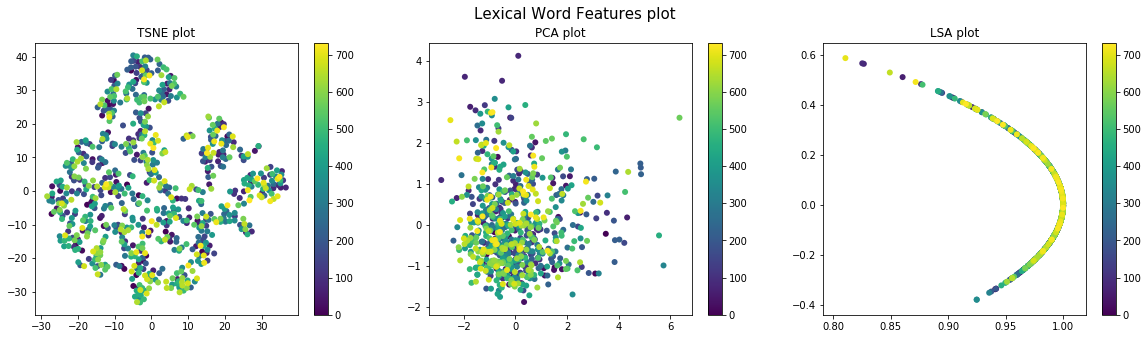

In [35]:
visualize(feature_sets[0], list(range(len(feature_sets[0]))), 'Lexical Word Features plot')

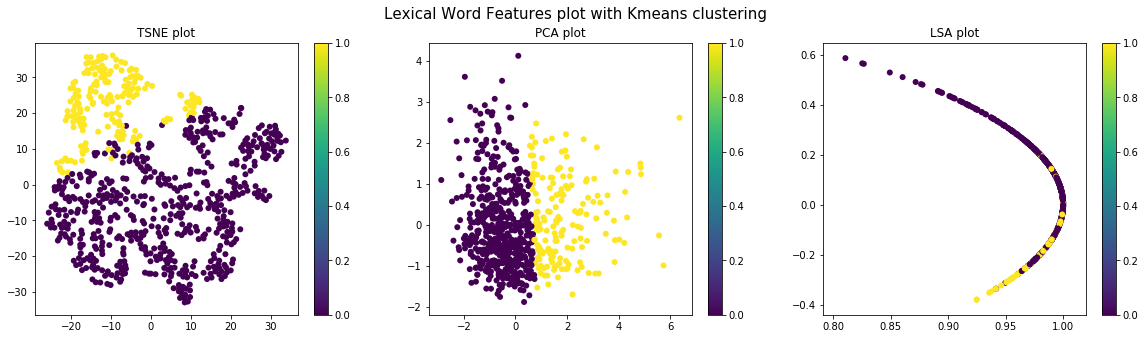

In [36]:
visualize(feature_sets[0], classificationDF1['LexicalFeaturesPred'], 
          'Lexical Word Features plot with Kmeans clustering')

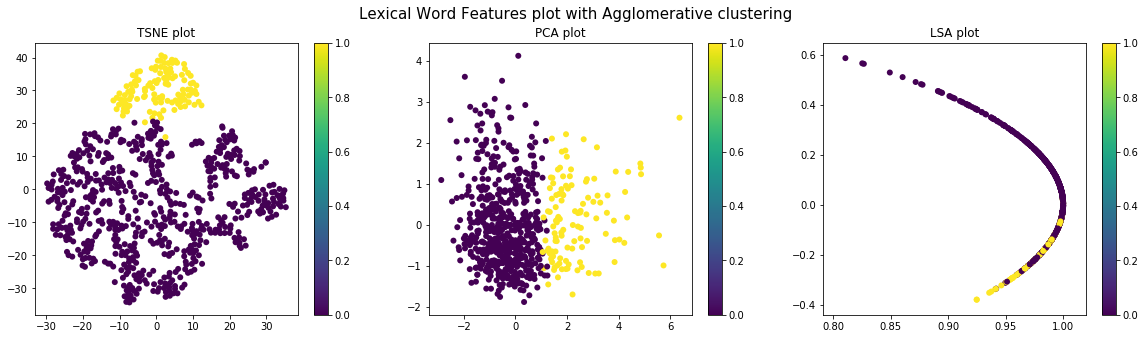

In [37]:
visualize(feature_sets[0], classificationAggDF1['LexicalFeaturesAggPred'], 
          'Lexical Word Features plot with Agglomerative clustering')

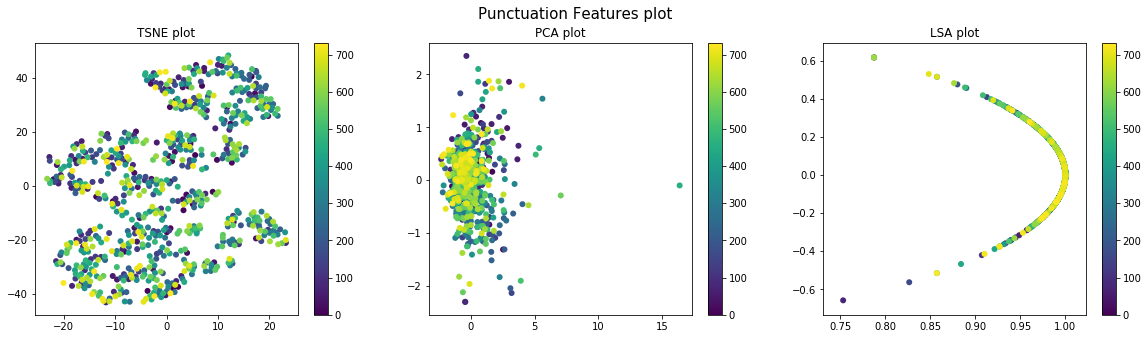

In [38]:
visualize(feature_sets[1], list(range(len(feature_sets[1]))), 'Punctuation Features plot')

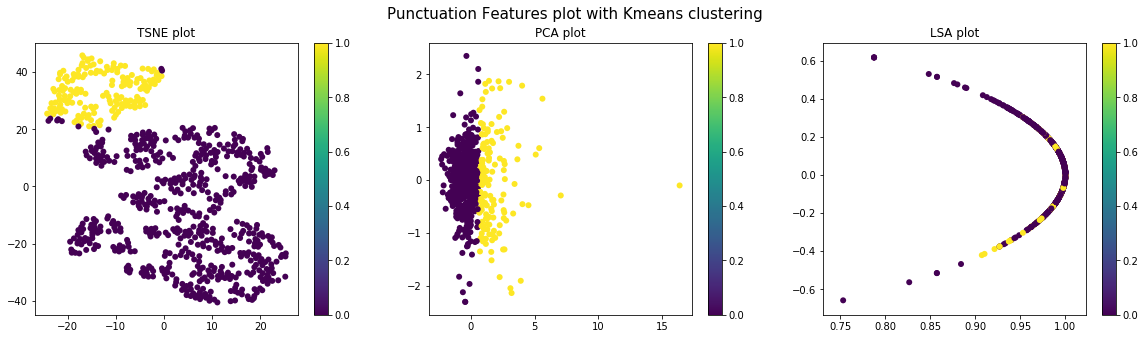

In [39]:
visualize(feature_sets[1], classificationDF1['PunctualFeaturesPred'], 
          'Punctuation Features plot with Kmeans clustering')

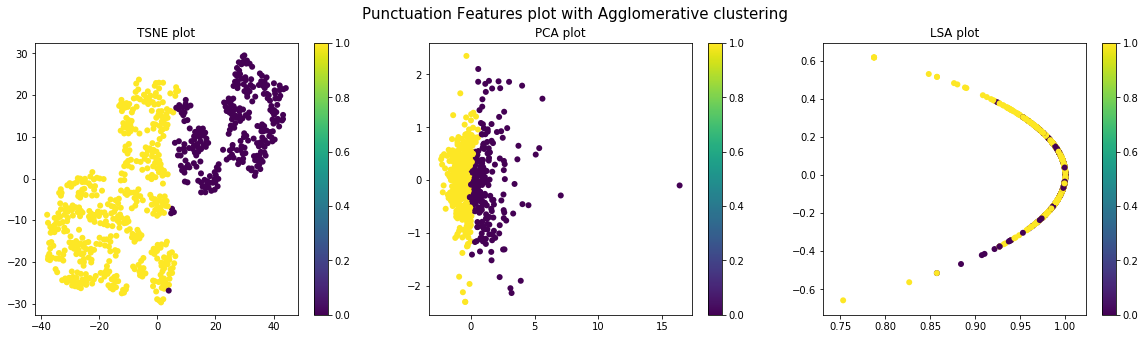

In [40]:
visualize(feature_sets[1], classificationAggDF1['PunctualFeaturesAggPred'],
          'Punctuation Features plot with Agglomerative clustering')

### Conclusion

A novel approach of feature extraction and ensemble voting by clustering is done in this assignment to determine the various play-sections which might have not been written by Shakespeare. An indepth feature extraction is done from the plays to identify the textual features that alltogether, encompass the writing signature of Shakespeare. K-means an Agglomerative clustering methods are applied to create two clusters. The majority cluster written by Shakespeare and the second, minority cluster, belonging to other authors. Visualisation is also used to see the distribution of the various sections and performance of clustering.